# Continnum substraction
應該是**連續譜的 fitting**

因為我的 cube 看起來（也確實是）沒減過連續譜的樣子  
這樣算比值絕對會出問題的吧啊！  
所以要先做這個  

- method ref :  
老豆，說用 line free 的地方 fit 就好?  

- IFU from :  
ESO Arcnive   
Instrument          : VLT MUSE(single)  
Object              : Circinus  
Range(air $\lambda$): 4759-9320 Å（補藥換成頻率啊）      
pID                 : 094.B-0321

- 0804 更新：  
從單一 pixel 的 fit 變成試圖 go through 整張圖了

In [228]:
# modular
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits

def fitModel(x, a, b): # 先定個線性
    return a * x + b

## for Both
共同的部分，啊英文不會寫哈哈

### Import data
讀進來的東西是確切的三維

In [ ]:
# 
c = 299792.458  # [km/s]
z = 0.001448 # circinus galaxy
commonPath = '/Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/'
file_path = f"{commonPath}MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits" # FITS

# metadata
muse_hdul = fits.open(file_path)
muse_hdul.info() # DATA:cube, STAT:noise?
muse_data = muse_hdul['DATA'].data # (RA, DEC, AWAV), 3D desu
muse_header = muse_hdul['DATA'].header

Filename: /Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1341   ()      
  1  DATA          1 ImageHDU        43   (317, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (317, 319, 3682)   float32   


#### 又來到了親愛的波長軸的環節了
稍微切了一下，因為旁邊用不太到

In [230]:
# entire AWV axis
crval3 = muse_header['CRVAL3']
cdelt3 = muse_header['CD3_3']
crpix3 = muse_header['CRPIX3']
naxis3 = muse_header['NAXIS3']
ori_lamb = crval3 + (np.arange(naxis3) + 1 - crpix3) * cdelt3 # [AA] in air

# analysis range
wmin, wmax = 4751, 6900 # [AA]
WLrange = (ori_lamb >= wmin) & (ori_lamb <= wmax) # '&' is a numpy operator!

# 切一下
lamb = ori_lamb[WLrange]
muse_partiData = muse_data[WLrange, :, :]

### Line free channel (wave lengh)
人類去圈的，可能在中心區比較正確...  
(旁邊的 absorbtion 是不是有點太多了)

In [231]:
# line free channs
where_is_linefree = [(4770.796, 4834.046), # [AA] in air
                     (5326.546, 5494.046),
                     (5612.796, 5757.796),
                     (5996.546, 6137.796),
                     (6400.296, 6475.296),
                     (6646.546, 6686.546),
                     (6757.796, 6807.796),
                     (7117.796, 7205.296)]

# 之前做過的對獎邏輯！但是忘記是在哪做的了啊啊
lineFree_channs = []
for i in range(int(lamb.shape[0])): # 做一個都是 0 的對獎紙
    lineFree_channs.append(0) 

for i in range(len(lamb)):
    for m, M in where_is_linefree:
        wav = float(lamb[i])
        if wav>m and wav<M:
            lineFree_channs[i] = 1 # 畫記

## Fit a pixel
先用的超簡單超乎天文的 fitting  
不知道對不對但 fit 得挺好啊

In [232]:
# 要 fit 哪個 pixel 的 continnum?
raP, decP = muse_partiData.shape[1]//2, muse_partiData.shape[2]//2 # certain pixel, 之後應該是要 gothrogh 的
pixx = muse_partiData[:, raP, decP]

In [233]:
# aqing's fitting
fitting_lamb = []
fitting_flux = [] # 存放 fit 材料
for i in range(len(lamb)):
    if lineFree_channs[i] == 1:
        fitting_lamb.append(lamb[i])
        fitting_flux.append(pixx[i])

fitting_lamb = np.array(fitting_lamb)
fitting_flux = np.array(fitting_flux)

popt, _ = curve_fit(fitModel, fitting_lamb, fitting_flux, absolute_sigma=False) # least square

### Product(a pixel)
感覺很不錯，就是不知道怎麼把資料取出來  
可以加點 chi2 ??? 學都學了  

In [234]:
# data product
fitting_result = fitModel(fitting_lamb, *popt) # 進行一個大代入，愛實驗物理學
emission_contsub = pixx - (fitModel(lamb, *popt))

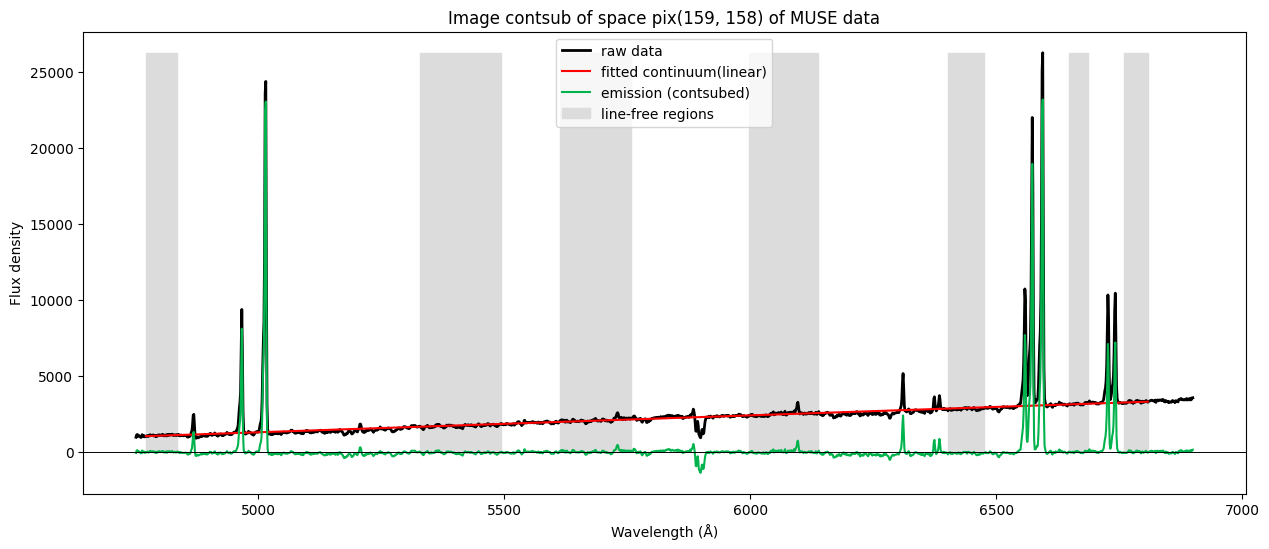

In [235]:
# 畫個
plt.figure(figsize=(15, 6))
plt.plot(lamb, pixx, c='k', lw=2, label='raw data')
plt.plot(fitting_lamb, fitting_result, c='r', label="fitted continuum(linear)")
plt.plot(lamb, emission_contsub, c=(0, 0.7, 0.3), label='emission (contsubed)')
plt.fill_between(lamb, -1, np.max(pixx), where=lineFree_channs, # 灰色格子是這樣做的
                 color='gainsboro', label="line-free regions")

plt.axhline(0, c='k', lw=0.7)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux density")
plt.title(f'Image contsub of space pix({raP}, {decP}) of MUSE data')

plt.legend(loc='upper center')
plt.show()

----

## Go throught entire image
哈哈沒寫完

In [ ]:
# 哇喔有 112591 個 pixels 耶
emission_contsub_all = []
for raP in range(muse_partiData.shape[1]):
    for decP in range(muse_partiData.shape[2]):
        pixx = muse_partiData[:, raP, decP]
        if np.isnan(pixx).any():
            print(f'({raP}, {decP}) is a bad pixel.')
            continue
        fitting_lamb = []
        fitting_flux = [] # 存放 fit 材料
        for i in range(len(lamb)):
            if lineFree_channs[i] == 1:
                fitting_lamb.append(lamb[i])
                fitting_flux.append(pixx[i])
        fitting_lamb = np.array(fitting_lamb)
        fitting_flux = np.array(fitting_flux)
        popt, _ = curve_fit(fitModel, fitting_lamb, fitting_flux, absolute_sigma=False) # least square
        #fitting_result = fitModel(fitting_lamb, *popt) # 也許這邊不需要這個？
        emission_contsub = pixx - (fitModel(lamb, *popt))
        emission_contsub_all.append(emission_contsub)
        

print('FIN')


(0, 0) is a bad pixel.
(0, 1) is a bad pixel.
(0, 2) is a bad pixel.
(0, 3) is a bad pixel.
(0, 4) is a bad pixel.
(0, 5) is a bad pixel.
(0, 6) is a bad pixel.
(0, 7) is a bad pixel.
(0, 8) is a bad pixel.
(0, 9) is a bad pixel.
(0, 10) is a bad pixel.
(0, 11) is a bad pixel.
(0, 12) is a bad pixel.
(0, 13) is a bad pixel.
(0, 14) is a bad pixel.
(0, 15) is a bad pixel.
(0, 16) is a bad pixel.
(0, 17) is a bad pixel.
(0, 18) is a bad pixel.
(0, 19) is a bad pixel.
(0, 20) is a bad pixel.
(0, 21) is a bad pixel.
(0, 22) is a bad pixel.
(0, 23) is a bad pixel.
(0, 24) is a bad pixel.
(0, 25) is a bad pixel.
(0, 26) is a bad pixel.
(0, 27) is a bad pixel.
(0, 28) is a bad pixel.
(0, 29) is a bad pixel.
(0, 30) is a bad pixel.
(0, 31) is a bad pixel.
(0, 32) is a bad pixel.
(0, 33) is a bad pixel.
(0, 34) is a bad pixel.
(0, 35) is a bad pixel.
(0, 36) is a bad pixel.
(0, 37) is a bad pixel.
(0, 38) is a bad pixel.
(0, 39) is a bad pixel.
(0, 40) is a bad pixel.
(0, 41) is a bad pixel.
(0